# Detached
## One hiden layer

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
#from google.colab import files

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
Nmin = -2 * np.pi
Nmax = 2 *  np.pi
N = 20

train_data = np.linspace(Nmin, Nmax, num=N)
train_label = np.sin(train_data)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# remove the top and right axes in figure to make it nicer.
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.hidden_size1 = hidden_size1
        self.fc1.weight.detach().normal_(0.0, 0.1)
        self.fc1.bias.detach().normal_(0.0, 0.1)


        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)
        self.fc2.weight.detach().normal_(0.0, 0.1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = out/np.sqrt(self.hidden_size1)
        return out

In [3]:
input_data = torch.from_numpy(train_data).reshape(-1, 1).to(device).float()
target = torch.from_numpy(train_label).reshape(-1, 1).to(device).float()

In [4]:
def calculate_delta_vec(model):
    # calculate the delta vector Eqn (18) of https://arxiv.org/pdf/1906.07842.pdf 
    with torch.no_grad():
          delta_vec = model.fc2.weight.flatten() ** 2  - model.fc1.weight.flatten() ** 2  - model.fc1.bias ** 2
    return delta_vec

def calculate_sign_chaning_points(model):
    # calculate the knot points.
    with torch.no_grad():
          sign_chaning_points = - model.fc1.bias.flatten() /  model.fc1.weight.flatten()
          # note here - model.fc1.bias.flatten() is used. This is because in pytorch bias in the affine transformation is added but not subtracted (unlike Eqn (1) of https://arxiv.org/pdf/1906.07842.pdf  ).
    return sign_chaning_points, model.forward(sign_chaning_points.reshape(-1, 1)).flatten()

def convert_to_uv(model, no_sgn = False):
    a, b, c = model.fc1.weight.data.cpu().flatten(), model.fc1.bias.data.cpu().flatten(), model.fc2.weight.data.cpu().flatten()         
    
    # u and v are derived by simplifying Eqn (6)  https://arxiv.org/pdf/1906.07842.pdf 
    u = abs(c) * a 
    v = abs(c) * b
    sgn_c = np.sign(c)

    pos_sgn_c_list = np.argwhere(sgn_c > 0)
    neg_sgn_c_list = np.argwhere(sgn_c < 0)

    pos_c_uv = (u[pos_sgn_c_list], v[pos_sgn_c_list])
    neg_c_uv = (u[neg_sgn_c_list], v[neg_sgn_c_list])

    if no_sgn == False:
      # return two tuples of (u, v), each corresponding to positive or negative value of c.
       return pos_c_uv, neg_c_uv
    else:
      # return all u, v altogether regardless of the sign of c.
       return (u, v)


def plot_fitted_curve(model, ax, Nmin = Nmin, Nmax = Nmax):
    # This function produces a figure in the fashion of the LEFT panel of Fig 1 of https://arxiv.org/pdf/1906.07842.pdf 

    with torch.no_grad():
        model_final_output = model(input_data).flatten().data.numpy()
        sign_chaning_points, mapped_sign_chaning_points = calculate_sign_chaning_points(model)

    ax.plot(train_data, train_label, linestyle = '-', linewidth = 5, label = 'Ground truth' )
    ax.plot(train_data, model_final_output, linestyle = ':', linewidth = 5, label = 'Learned' )
    ax.plot(sign_chaning_points.data.numpy(), mapped_sign_chaning_points.data.numpy(), 'go',  markersize = 5, label = 'Relu sign change points' )

    mean_delta = round( np.float( calculate_delta_vec(model).mean()), 2)

    if mean_delta > 0:
       regime_str = 'Adaptive regime;'
    else:
       regime_str = 'Kernel regime;'

    ax.set_title(regime_str + ' Avg. delta = ' + str(mean_delta) , fontsize = 16)
    ax.legend(loc = 2, frameon = False, fontsize = 14)
    ax.set_xlim([Nmin,Nmax])
    ax.set_ylim([-1.5,2.2])
    ax.set_xlabel('Domain', fontsize = 16)
    ax.set_ylabel('Range', fontsize = 16)
    return ax

def plot_particles(model, ax, scatter_bool = True):
    # This function produces a figure in the fashion of the RIGHT panel of Fig 1 of https://arxiv.org/pdf/1906.07842.pdf 

    pos_c_uv, neg_c_uv = convert_to_uv(model)

    concat_pos = np.concatenate( [pos_c_uv[0].flatten(),  neg_c_uv[0].flatten() ] )

    plot_end_point = np.abs(concat_pos).max()

    ux_list = np.linspace(- plot_end_point, plot_end_point, num=100) 
    uy_list = np.array([-ux * input_data.flatten().numpy() for ux in ux_list] )

    # plot the particles 
    if scatter_bool:
        ax.scatter(pos_c_uv[0], pos_c_uv[1], c = 'b', label = 'r > 0')
        ax.scatter(neg_c_uv[0], neg_c_uv[1], c = 'r', label = 'r < 0')

    for i in range(len(input_data)):
        ax.plot(ux_list, uy_list[:, i], ':')
    ax.legend(frameon = False, fontsize = 14)

    mean_delta = round( np.float( calculate_delta_vec(model).mean()), 2)

    if mean_delta > 0:
       regime_str = 'Adaptive regime;'
    else:
       regime_str = 'Kernel regime;'

    ax.set_title(regime_str + ' Avg. delta = ' + str(mean_delta) , fontsize = 16)

    return ax

def plot_particle_traj(model, traj, ax, num_traj = 20):
    # This function produces a figure in the fashion of the those in the last row of Fig 6 in the appendix of https://arxiv.org/pdf/1906.07842.pdf.

    ax = plot_particles(model, ax, scatter_bool = False)

    all_u = np.array([traj[i][0].data.cpu().numpy() for i in range(len(traj) ) ] )
    all_v = np.array([traj[i][1].data.cpu().numpy() for i in range(len(traj) ) ] )

    for i in range(num_traj):
    # i = 38
        ax.plot(all_u[:, i], all_v[:, i], '-', linewidth = 3, markersize = 8)

        pos_x = all_u[:, i][-1]
        pos_y = all_v[:, i][-1]

        moving_diff = np.array( [all_u[:, i][1:] - all_u[:, i][:-1], all_v[:, i][1:] - all_v[:, i][:-1] ] ) 

        dx = moving_diff.mean(axis = 1)[0]
        dy = moving_diff.mean(axis = 1)[1]
        ax.quiver(pos_x, pos_y, dx, dy, angles='xy', scale_units='xy', units='width', headwidth = 2)

        ax.set_xlim([-2, 2 ] )
        ax.set_ylim([-10, 10 ] )

    return ax


In [5]:
def fit_model(model, learning_rate, criterion = nn.MSELoss(), num_epochs = 20000, layer1_scaling = 1.0, layer2_scaling = 1.0, return_abc = False):

    model.fc1.weight = torch.nn.Parameter( layer1_scaling * model.fc1.weight)
    model.fc1.bias = torch.nn.Parameter( layer1_scaling * model.fc1.bias)
    model.fc2.weight = torch.nn.Parameter( layer2_scaling * model.fc2.weight)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # delta_vec_list = []
    traj_list = []
    traj_abc_list = []
    for epoch in range(num_epochs):

        # Forward pass
        outputs = model(input_data)
        loss = criterion(outputs, target)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if epoch % 1000 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            uv = convert_to_uv(model, no_sgn = True)
            traj_list.append(uv)
            
            a, b, c = model.fc1.weight.data.cpu().flatten().clone(), model.fc1.bias.data.cpu().flatten().clone(), model.fc2.weight.data.cpu().flatten().clone()         
#             print(a[:5])
            traj_abc_list.append([a, b, c])

#             print(model.fc1.weight.data.cpu().flatten()[:10])
#             traj_abc_list.append([model.fc1.weight.data.cpu().flatten(), model.fc1.bias.data.cpu().flatten(), model.fc2.weight.data.cpu().flatten()])
            
    if return_abc:
        return model, traj_list, traj_abc_list           
    else:        
        return model, traj_list   

# Train a neural net in the kernel regime

In [6]:
torch.manual_seed(0)
kernel_regime_model = NeuralNet(input_size = 1, hidden_size1 = 1000, num_classes = 1).to(device)
learned_kernel_regime_model, traj_list_kernel_regime = fit_model(kernel_regime_model, learning_rate = 0.01, layer1_scaling = 70.0, layer2_scaling = 0.001, num_epochs = 40000)

Epoch [1/40000], Loss: 0.4754
Epoch [1001/40000], Loss: 0.5385
Epoch [2001/40000], Loss: 0.4061
Epoch [3001/40000], Loss: 0.3266
Epoch [4001/40000], Loss: 0.2767
Epoch [5001/40000], Loss: 0.2440
Epoch [6001/40000], Loss: 0.2212
Epoch [7001/40000], Loss: 0.2039
Epoch [8001/40000], Loss: 0.1898
Epoch [9001/40000], Loss: 0.1775
Epoch [10001/40000], Loss: 0.1664
Epoch [11001/40000], Loss: 0.1558
Epoch [12001/40000], Loss: 0.1454
Epoch [13001/40000], Loss: 0.1354
Epoch [14001/40000], Loss: 0.1252
Epoch [15001/40000], Loss: 0.1147
Epoch [16001/40000], Loss: 0.1035
Epoch [17001/40000], Loss: 0.0919
Epoch [18001/40000], Loss: 0.0802
Epoch [19001/40000], Loss: 0.0689
Epoch [20001/40000], Loss: 0.0582
Epoch [21001/40000], Loss: 0.0487
Epoch [22001/40000], Loss: 0.0405
Epoch [23001/40000], Loss: 0.0339
Epoch [24001/40000], Loss: 0.0287
Epoch [25001/40000], Loss: 0.0248
Epoch [26001/40000], Loss: 0.0218
Epoch [27001/40000], Loss: 0.0195
Epoch [28001/40000], Loss: 0.0178
Epoch [29001/40000], Loss: 

# Train a neural net in the adaptive regime

In [6]:
torch.manual_seed(1)
adaptive_regime_model = NeuralNet(input_size = 1, hidden_size1 = 1000, num_classes = 1).to(device)
learned_adaptive_regime_model, traj_list_adaptive_regime, traj_list_abc_adaptive_regime  = fit_model(adaptive_regime_model, learning_rate = 0.01, layer1_scaling =  0.1, layer2_scaling = 50, num_epochs = 40000, return_abc = True)



Epoch [1/40000], Loss: 0.4714
Epoch [1001/40000], Loss: 0.1688
Epoch [2001/40000], Loss: 0.1495
Epoch [3001/40000], Loss: 0.1327
Epoch [4001/40000], Loss: 0.1180
Epoch [5001/40000], Loss: 0.1052
Epoch [6001/40000], Loss: 0.0940
Epoch [7001/40000], Loss: 0.0842
Epoch [8001/40000], Loss: 0.0757
Epoch [9001/40000], Loss: 0.0684
Epoch [10001/40000], Loss: 0.0622
Epoch [11001/40000], Loss: 0.0571
Epoch [12001/40000], Loss: 0.0529
Epoch [13001/40000], Loss: 0.0492
Epoch [14001/40000], Loss: 0.0461
Epoch [15001/40000], Loss: 0.0436
Epoch [16001/40000], Loss: 0.0414
Epoch [17001/40000], Loss: 0.0394
Epoch [18001/40000], Loss: 0.0376
Epoch [19001/40000], Loss: 0.0361
Epoch [20001/40000], Loss: 0.0346
Epoch [21001/40000], Loss: 0.0334
Epoch [22001/40000], Loss: 0.0322
Epoch [23001/40000], Loss: 0.0312
Epoch [24001/40000], Loss: 0.0302
Epoch [25001/40000], Loss: 0.0293
Epoch [26001/40000], Loss: 0.0285
Epoch [27001/40000], Loss: 0.0277
Epoch [28001/40000], Loss: 0.0270
Epoch [29001/40000], Loss: 

In [38]:
traj_list_abc_adaptive_regime[0][0] - traj_list_abc_adaptive_regime[1][0]

tensor([ 0.0000e+00, -7.4353e-03, -8.4443e-03,  0.0000e+00, -7.6564e-03,
         1.2080e-02, -3.3434e-07,  2.5757e-02,  2.2075e-03,  1.1531e-02,
        -6.3404e-03,  1.2522e-02, -1.2087e-02, -2.4218e-03,  4.7529e-03,
         1.8131e-02, -1.1574e-03,  9.0566e-03,  1.2424e-03, -1.2353e-03,
         1.7497e-02,  1.6469e-04,  2.6445e-02, -2.8870e-02,  1.2792e-02,
         2.4963e-03, -3.1236e-04, -1.2868e-03, -1.6888e-03,  3.7970e-05,
        -3.0511e-02,  1.1681e-02, -2.5982e-03,  1.7577e-03,  3.5718e-03,
        -2.7907e-03, -1.1616e-02,  6.6878e-03, -1.1312e-03,  0.0000e+00,
        -6.5232e-03,  0.0000e+00, -4.3397e-03,  0.0000e+00,  9.4750e-04,
         1.8605e-03,  3.0168e-03, -3.1867e-02, -1.8858e-02, -1.1119e-03,
        -1.3541e-02,  4.9137e-03,  1.8301e-02,  8.9392e-04, -2.2416e-03,
         6.9463e-03,  1.3117e-03,  2.7132e-03, -2.2527e-03,  7.9495e-04,
        -2.0458e-04,  3.6085e-04, -8.5530e-03,  8.1528e-03,  1.8704e-04,
        -6.7213e-03, -2.6760e-02,  5.7786e-03,  2.1

tensor([-0.0008,  0.0134,  0.0779, -0.0003,  0.0714, -0.0116,  0.0062, -0.1409,
         0.1132, -0.1592])

# Visualize both nets 

NameError: name 'learned_kernel_regime_model' is not defined

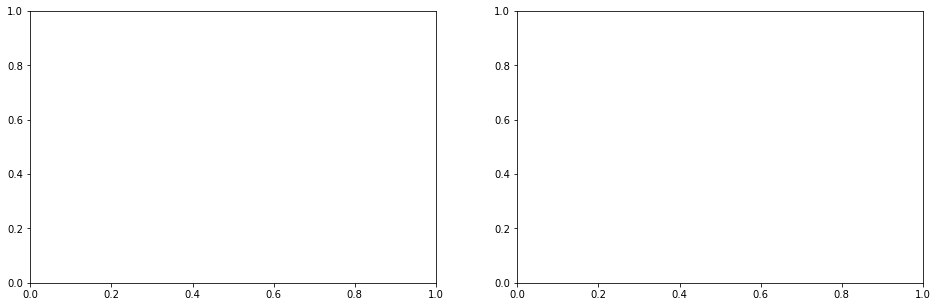

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
ax = axes[0]
ax = plot_fitted_curve(learned_kernel_regime_model, ax)
ax = simpleaxis(ax)

ax = axes[1]
ax = plot_fitted_curve(learned_adaptive_regime_model, ax)
ax = simpleaxis(ax)

# plt.savefig("fitted_curve.png", dpi=800)
# files.download("fitted_curve.png") 


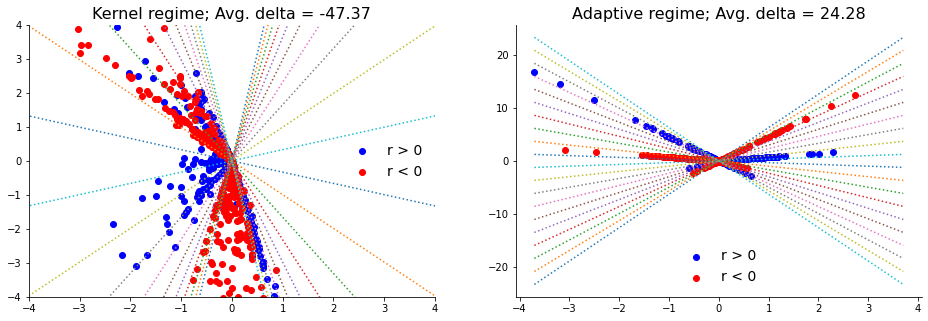

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
ax = axes[0]
ax = plot_particles(learned_kernel_regime_model, ax, scatter_bool = True)
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
ax = simpleaxis(ax)

ax = axes[1]
ax = plot_particles(learned_adaptive_regime_model, ax)
ax = simpleaxis(ax)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/shi0000/Anaconda/envs/test/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/shi0000/Anaconda/envs/test/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


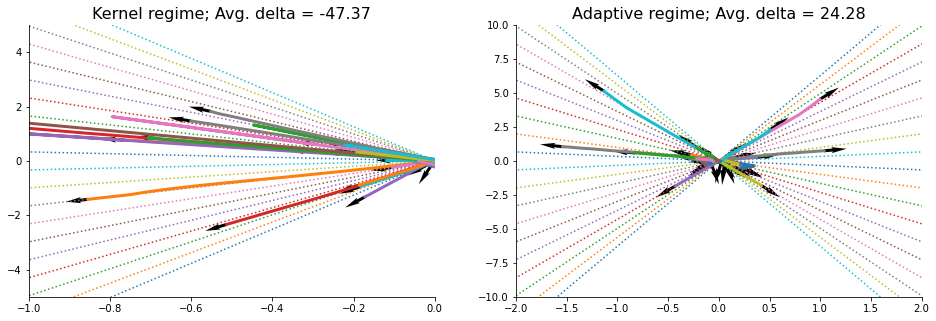

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
ax = axes[0]
ax = plot_particle_traj(learned_kernel_regime_model, traj = traj_list_kernel_regime,  ax = ax, num_traj = 50)
ax.set_xlim([-1,0])
ax.set_ylim([-5,5])
ax = simpleaxis(ax)



ax = axes[1]
ax = plot_particle_traj(learned_adaptive_regime_model, traj = traj_list_adaptive_regime, ax = ax, num_traj = 50)
ax = simpleaxis(ax)

plt.savefig("particles_traj.png", dpi=800)
# files.download("particles_traj.png") 



## Threshold delta value 

No handles with labels found to put in legend.


463


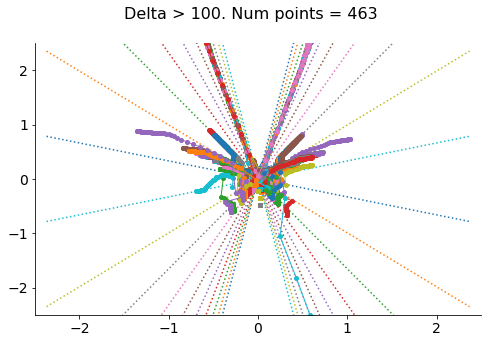

In [126]:
fig, ax = plt.subplots( figsize=(8,5))

model = learned_adaptive_regime_model
traj = traj_list_adaptive_regime
thres = 100

thres_above_indices = np.where(calculate_delta_vec(model) > thres )[0]
print(len(thres_above_indices))
ax = plot_particles(model, ax, scatter_bool = False)

all_u = np.array([traj[i][0].data.cpu().numpy() for i in range(len(traj) ) ] )
all_v = np.array([traj[i][1].data.cpu().numpy() for i in range(len(traj) ) ] )

all_u = all_u[:, thres_above_indices ]
all_v = all_v[:, thres_above_indices ]

for i in range(len(thres_above_indices)):
    if i> len(thres_above_indices)/3:
        break
    ax.plot(all_u[:, i], all_v[:, i], '.-', linewidth = 1, markersize = 8)
    #ax.plot(all_u[:, i], all_v[:, i], 'x', markersize = 8)

    pos_x = all_u[:, i][-1]
    pos_y = all_v[:, i][-1]

    moving_diff = np.array( [all_u[:, i][1:] - all_u[:, i][:-1], all_v[:, i][1:] - all_v[:, i][:-1] ] ) 

    dx = moving_diff.mean(axis = 1)[0]
    dy = moving_diff.mean(axis = 1)[1]
    # ax.quiver(pos_x, pos_y, dx, dy, angles='xy', scale_units='xy', units='width', headwidth = 4)

    ax.set_xlim([-1, 1 ] )
    ax.set_ylim([-5, 5 ] )

ax.tick_params(axis='both', which='major', labelsize=14)
ax = simpleaxis(ax)
plt.title('')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
plt.suptitle('Delta > 100. Num points = ' + str(len(thres_above_indices)), fontsize = 16)
plt.savefig('adaptiveoriginal.png')

No handles with labels found to put in legend.


979


Text(0.5, 0.98, 'Delta < 10. Num points = 979')

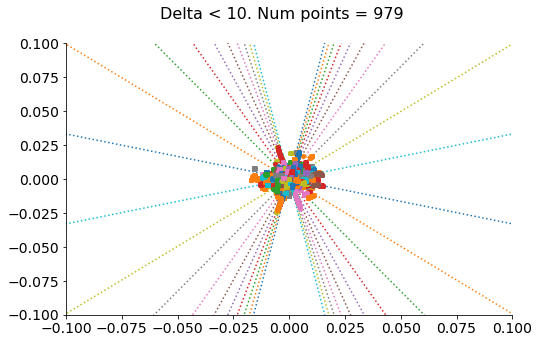

In [117]:
fig, ax = plt.subplots( figsize=(8,5))

model = learned_adaptive_regime_model
traj = traj_list_adaptive_regime
thres = 0.4
thres_below_indices = np.where(calculate_delta_vec(model) < thres )[0]
print(len(thres_below_indices) )
ax = plot_particles(model, ax, scatter_bool = False)

all_u = np.array([traj[i][0].data.cpu().numpy() for i in range(len(traj) ) ] )
all_v = np.array([traj[i][1].data.cpu().numpy() for i in range(len(traj) ) ] )

all_u = all_u[:, thres_below_indices ]
all_v = all_v[:, thres_below_indices ]

for i in range(len(thres_below_indices)):
    
    
    ax.plot(all_u[:, i], all_v[:, i], '.-', linewidth = 1, markersize = 8)
    
    #ax.plot(all_u[:, i], all_v[:, i], 'x', markersize = 8)
    
    
    pos_x = all_u[:, i][-1]
    pos_y = all_v[:, i][-1]

    # moving_diff = normalize(np.array( [all_u[:, i][1:] - all_u[:, i][:-1], all_v[:, i][1:] - all_v[:, i][:-1] ] ) )
    moving_diff = np.array( [all_u[:, i][1:] - all_u[:, i][:-1], all_v[:, i][1:] - all_v[:, i][:-1] ] ) 

    dx = moving_diff.mean(axis = 1)[0]
    dy = moving_diff.mean(axis = 1)[1]
    # ax.quiver(pos_x, pos_y, dx, dy, angles='xy', scale_units='xy', units='width', headwidth = 4)

    ax.set_xlim([-1, 1] )
    ax.set_ylim([-5, 5] )

ax.tick_params(axis='both', which='major', labelsize=14)
ax = simpleaxis(ax)
# plt.suptitle('Delta < ' + str(thres), fontsize = 16)
plt.title('')
plt.xlim([-0.1,0.1])
plt.ylim([-0.1,0.1])
plt.suptitle('Delta < 10. Num points = ' + str(len(thres_below_indices)), fontsize = 16)

No handles with labels found to put in legend.


545
[  0   1   2   3   4   5   7   8   9  10  11  13  14  17  18  19  21  23
  25  26  27  28  29  30  31  35  36  38  39  42  44  45  47  50  55  56
  57  59  61  63  64  65  68  69  70  72  73  77  79  80  81  83  85  86
  89  92  96  98  99 103 105 109 112 113 114 117 118 121 125 129 130 132
 135 136 137 138 139 140 141 145 148 150 151 153 155 156 157 158 160 161
 163 166 169 170 171 173 175 176 177 178 179 181 185 188 189 190 192 193
 195 196 197 200 201 203 204 205 206 207 209 211 212 214 215 216 218 219
 222 227 228 229 230 233 234 235 238 239 241 244 245 249 250 255 257 260
 261 262 263 264 265 266 267 268 271 272 274 275 276 278 280 283 287 288
 289 291 294 296 297 298 300 301 302 303 304 305 307 309 318 321 323 324
 325 330 334 337 338 340 341 342 344 350 352 354 356 358 360 362 363 364
 367 369 372 373 376 377 379 380 381 382 383 384 386 387 388 389 390 392
 397 399 400 401 403 406 407 408 409 410 412 413 415 417 418 420 422 425
 427 428 429 431 434 435 436 437 439 440 442 44

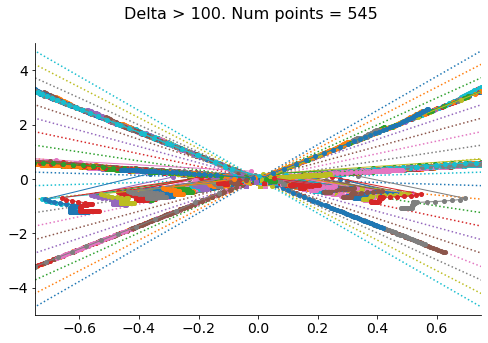

In [8]:
fig, ax = plt.subplots( figsize=(8,5))

model = learned_adaptive_regime_model
traj = traj_list_adaptive_regime
thres = 10

thres_above_indices = np.where(calculate_delta_vec(model) > thres )[0]
print(len(thres_above_indices))
print(thres_above_indices)
ax = plot_particles(model, ax, scatter_bool = False)

all_u = np.array([traj[i][0].data.cpu().numpy() for i in range(len(traj) ) ] )
all_v = np.array([traj[i][1].data.cpu().numpy() for i in range(len(traj) ) ] )

all_u = all_u[:, thres_above_indices ]
all_v = all_v[:, thres_above_indices ]

for i in range(len(thres_above_indices)):
    ax.plot(all_u[:, i], all_v[:, i], '.-', linewidth = 1, markersize = 8)
    #ax.plot(all_u[:, i], all_v[:, i], 'x', markersize = 8)

    pos_x = all_u[:, i][-1]
    pos_y = all_v[:, i][-1]

    moving_diff = np.array( [all_u[:, i][1:] - all_u[:, i][:-1], all_v[:, i][1:] - all_v[:, i][:-1] ] ) 

    dx = moving_diff.mean(axis = 1)[0]
    dy = moving_diff.mean(axis = 1)[1]
    # ax.quiver(pos_x, pos_y, dx, dy, angles='xy', scale_units='xy', units='width', headwidth = 4)

    ax.set_xlim([-1, 1 ] )
    ax.set_ylim([-5, 5 ] )

ax.tick_params(axis='both', which='major', labelsize=14)
ax = simpleaxis(ax)
plt.title('')
plt.xlim([-0.75,0.75])
#plt.ylim([-1,0])
plt.suptitle('Delta > 100. Num points = ' + str(len(thres_above_indices)), fontsize = 16)
plt.savefig('adaptive1.png')

[]

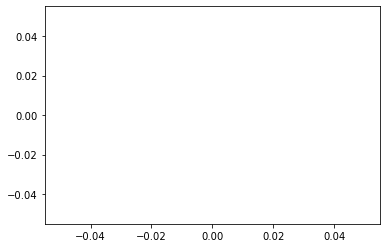

In [96]:
plt.plot()

In [86]:
print(traj_list_abc_adaptive_regime[11][0][0])

tensor(-0.0008)


In [87]:
traj_list_abc_adaptive_regime[0][0]

tensor([-8.3941e-04,  1.3416e-02,  7.7881e-02, -2.6821e-04,  7.1387e-02,
        -1.1620e-02,  6.2383e-03, -1.4093e-01,  1.1319e-01, -1.5919e-01,
         1.0719e-02, -1.0624e-01,  1.6541e-02, -2.6236e-02, -1.1171e-01,
        -1.8516e-02, -8.8791e-02, -1.8743e-02,  2.6583e-02, -6.2785e-04,
        -1.5563e-02,  8.8245e-03, -1.0637e-01,  2.5051e-02, -4.8968e-02,
        -1.2708e-02, -4.9390e-03,  4.3733e-02,  3.5149e-02, -9.3004e-03,
         2.6043e-02, -8.8050e-03, -1.3808e-04, -3.1192e-02,  3.2135e-04,
         1.1002e-02,  1.4381e-01, -3.9987e-02,  5.7999e-02,  8.4864e-04,
         7.8446e-03,  7.3976e-04, -6.8543e-02, -9.7283e-04, -6.4812e-03,
        -2.6501e-02, -5.5548e-02,  1.2581e-01,  1.7865e-02,  1.0200e-01,
         1.5528e-01, -3.5719e-02, -1.7891e-02, -2.2064e-03, -5.4391e-02,
        -1.0613e-02,  2.3280e-04, -3.7307e-02,  4.9245e-02, -3.2103e-03,
        -9.3526e-02, -1.0235e-02,  8.2060e-03, -3.5646e-02,  6.5964e-03,
         3.7972e-02,  1.9263e-02, -4.9474e-02, -4.8

In [89]:
traj_list_abc_adaptive_regime[1][0]

tensor([-8.3941e-04,  1.3416e-02,  7.7881e-02, -2.6821e-04,  7.1387e-02,
        -1.1620e-02,  6.2383e-03, -1.4093e-01,  1.1319e-01, -1.5919e-01,
         1.0719e-02, -1.0624e-01,  1.6541e-02, -2.6236e-02, -1.1171e-01,
        -1.8516e-02, -8.8791e-02, -1.8743e-02,  2.6583e-02, -6.2785e-04,
        -1.5563e-02,  8.8245e-03, -1.0637e-01,  2.5051e-02, -4.8968e-02,
        -1.2708e-02, -4.9390e-03,  4.3733e-02,  3.5149e-02, -9.3004e-03,
         2.6043e-02, -8.8050e-03, -1.3808e-04, -3.1192e-02,  3.2135e-04,
         1.1002e-02,  1.4381e-01, -3.9987e-02,  5.7999e-02,  8.4864e-04,
         7.8446e-03,  7.3976e-04, -6.8543e-02, -9.7283e-04, -6.4812e-03,
        -2.6501e-02, -5.5548e-02,  1.2581e-01,  1.7865e-02,  1.0200e-01,
         1.5528e-01, -3.5719e-02, -1.7891e-02, -2.2064e-03, -5.4391e-02,
        -1.0613e-02,  2.3280e-04, -3.7307e-02,  4.9245e-02, -3.2103e-03,
        -9.3526e-02, -1.0235e-02,  8.2060e-03, -3.5646e-02,  6.5964e-03,
         3.7972e-02,  1.9263e-02, -4.9474e-02, -4.8

In [39]:
def getabc(traj_list_abc_adaptive_regime,index):
    a=np.zeros(len(traj_list_abc_adaptive_regime))
    b=np.zeros(len(traj_list_abc_adaptive_regime))
    c=np.zeros(len(traj_list_abc_adaptive_regime))
    for i in range(len(traj_list_abc_adaptive_regime)):
        a[i]=traj_list_abc_adaptive_regime[i][0][index]
        b[i]=traj_list_abc_adaptive_regime[i][1][index]
        c[i]=traj_list_abc_adaptive_regime[i][2][index]
    return a,b,c

In [91]:
acount=0
bcount=0
for i in range(1000):
    a,b,c=getabc(traj_list_abc_adaptive_regime,i)
    if a[0]*a[39]<0:
        acount=acount+1
    if b[0]*b[39]<0:
        bcount=bcount+1
print(acount,bcount)

18 257


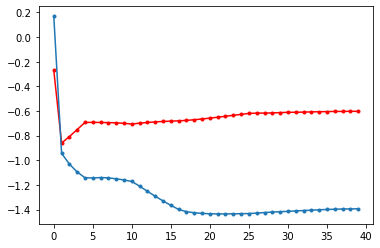

In [93]:
a,b,c=getabc(traj_list_abc_adaptive_regime,474)
plt.plot(c*a,'.-',color='red')
plt.plot(c*b,'.-')

#plt.plot(c)
#plt.plot(b/a,'.-')

(-1.5, -1.0)

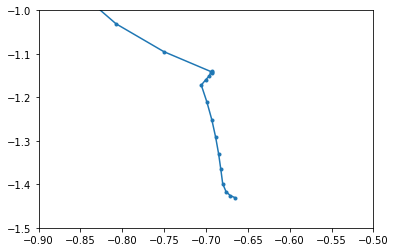

In [72]:
plt.plot((c*a)[:20],(c*b)[:20],'.-')
plt.xlim([-0.9,-0.5])
plt.ylim([-1.5,-1])

In [65]:
print(a)

[-0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438
 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438
 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438
 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438
 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438
 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438 -0.04205438
 -0.04205438 -0.04205438 -0.04205438 -0.04205438]


In [76]:
traj_list_abc_adaptive_regime[8][1][474]

tensor(-0.0973)

In [78]:
c**2-a**2-b**2

array([204.9285871, 204.9285871, 204.9285871, 204.9285871, 204.9285871,
       204.9285871, 204.9285871, 204.9285871, 204.9285871, 204.9285871,
       204.9285871, 204.9285871, 204.9285871, 204.9285871, 204.9285871,
       204.9285871, 204.9285871, 204.9285871, 204.9285871, 204.9285871,
       204.9285871, 204.9285871, 204.9285871, 204.9285871, 204.9285871,
       204.9285871, 204.9285871, 204.9285871, 204.9285871, 204.9285871,
       204.9285871, 204.9285871, 204.9285871, 204.9285871, 204.9285871,
       204.9285871, 204.9285871, 204.9285871, 204.9285871, 204.9285871])